In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, r2_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_selection import rfe, SelectKBest, f_classif, f_regression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

%matplotlib inline

In [5]:
file = 'appointments2016.csv'
data = pd.read_csv(file)
data.shape

(110527, 116)

## BASELINE 2016

In [6]:
baseline = 1 - data['No-show'].sum()/len(data['No-show'])
print(baseline)
print(1-baseline)
total_no_shows = data['No-show'].sum()
print(total_no_shows)
print(data.isnull().sum().sum())

0.798067440534892
0.20193255946510802
22319
0


In [7]:
features_to_ignore = ['DateAppointment','TimeScheduled', 'DateScheduled', 'AppointmentID',\
                      'PatientId', 'No-show', 'Neighborhood']
valid_features = [c for c in data.columns if c not in features_to_ignore]
len(valid_features)

109

In [8]:
valid_features.append('No-show')
features_corr = data[valid_features].corr()['No-show'].apply(lambda x: abs(x)).sort_values(ascending=False)
valid_features.remove('No-show')
featuresCorr = features_corr.index[1:]
len(featuresCorr), len(features_corr)

(109, 110)

In [26]:
llista = featuresCorr[0:5]

X = data[llista]
y = data['No-show']
    #intents = round(len(valid_features)/(len(valid_features)/(num_tries)))

X_train, X_test, y_train, y_test = train_test_split(X,y)
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)
model = GradientBoostingClassifier()
model.fit(Xs_train, y_train)
model.score(Xs_test, y_test)
predicted = model.predict(Xs_test)
acc = accuracy_score(y_test, predicted)
print(acc, baseline)

0.806818181818 0.798067440534892


In [28]:
len(model.feature_importances_), len(X_train.columns)

(5, 5)

In [29]:
conma = np.array(confusion_matrix(y_test, predicted, labels=[1,0]))

confusion = pd.DataFrame(conma, index=['Absent', 'No_absent'],
                         columns=['predicted_Absent','predicted_No_absent'])
confusion

,predicted_Absent,predicted_No_absent
Absent,279,5132
No_absent,206,22015


In [30]:
tp = confusion.iat[0,0]#268
fp = confusion.iat[1,0]#197
fn = confusion.iat[0,1]#5188
tn = confusion.iat[1,1]#21979
precision = tp/(tp+fp)
recall = tp/(tp+fn)##Sensitivity 1-FNR
true_negative_rate = tn/(tn+fp)#Specificity 1-FPR
accuracy = (tp + tn)/(tp + tn +fp +fn)
precision, recall, true_negative_rate, accuracy

(0.57525773195876284,
 0.051561633709111071,
 0.99072949012195666,
 0.80681818181818177)

In [36]:
mytuple = list(zip(X_train.columns, model.feature_importances_))
mytuple

[('awaiting_time', 0.46896678835837446),
 ('SMS_received', 0.039889173975171929),
 ('num_app_missed', 0.16020765206601667),
 ('Age', 0.26433713034199535),
 ('session', 0.066599255258441514)]

In [37]:
mytuple.sort(key=lambda x: x[1])
mytuple.reverse()
mytuple
name = []
coef = []
for nom, co in mytuple:
    name.append(nom)
    coef.append(co)
print(name, coef)

['awaiting_time', 'Age', 'num_app_missed', 'session', 'SMS_received'] [0.46896678835837446, 0.26433713034199535, 0.16020765206601667, 0.066599255258441514, 0.039889173975171929]


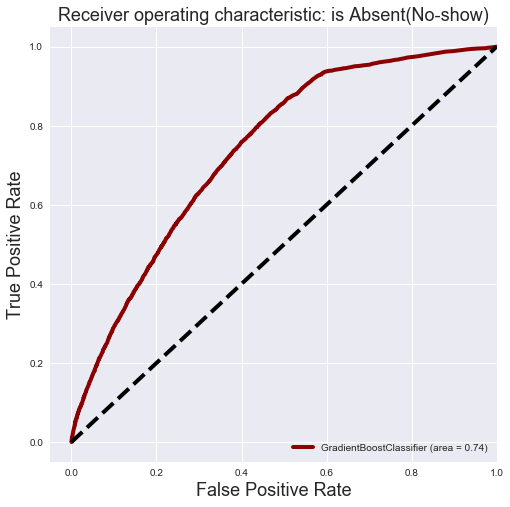

In [33]:
from sklearn.metrics import roc_curve, auc
fpr_rf, tpr_rf, _ = roc_curve(y_test, model.predict_proba(Xs_test)[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=[8,8])
#yhat_rf = rf.predict(Xs_test)
#plt.plot(fpr, tpr, label='Original (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot(fpr_rf, tpr_rf, label='GradientBoostClassifier (area = %0.2f)' % roc_auc_rf, 
         linewidth=4, color='darkred')
#plt.plot(fpr_lasso, tpr_lasso, label='Lasso (area = %0.2f)' % roc_auc_lasso, 
         #linewidth=4, color='darkgoldenrod')

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is Absent(No-show)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

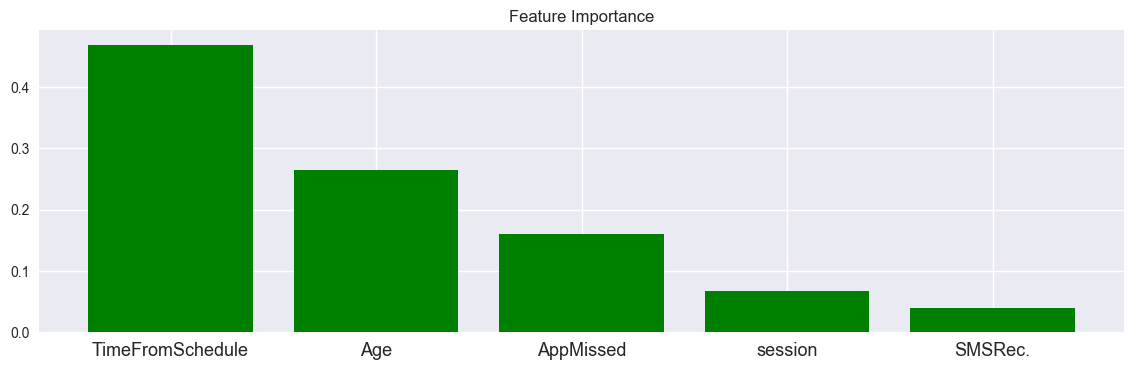

In [35]:
fig = plt.figure(figsize=(14, 4), dpi=100)
plt.title("Feature Importance")
plt.bar(range(len(model.feature_importances_[0:5])), coef, color='g')
categories = ['TimeFromSchedule', 'Age', 'AppMissed', 'session', 'SMSRec.']
plt.xticks(range(5), categories, fontsize =13)
plt.show()

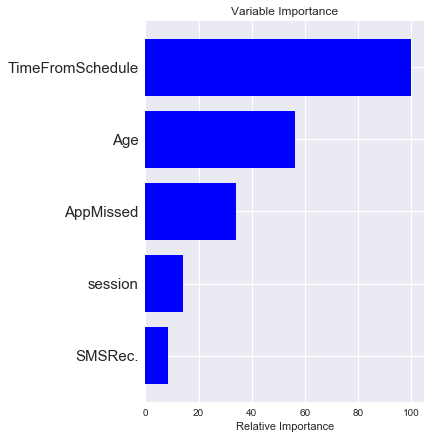

In [46]:
# make importances relative to max importance
feature_importance = 100.0 * (coef / max(coef))
sorted_idx = np.argsort(coef)
pos = np.arange(sorted_idx.shape[0]) + .8
noms = ['TimeFromSchedule', 'Age', 'AppMissed', 'session', 'SMSRec.']
plt.subplots(figsize=(5,7))
plt.barh(pos,feature_importance[::-1], align='center',color='b')
plt.yticks(pos, noms[::-1], fontsize =15)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()